In [9]:
from time import time
import logging
import pylab as pl
import numpy as np

from sklearn.cross_validation import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import RandomizedPCA
from sklearn.svm import SVC

# Pretty display for notebooks
%matplotlib inline

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

In [10]:
# Download the data and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspecting the images arrays to find the shapes
n_samples, h, w = lfw_people.images.shape
np.random.seed(42)

# for machine learning we use the data directly
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print ("Total dataset size:")
print ("n_samples: %d" % n_samples)
print ("n_features: %d" % n_features)
print ("n_classes: %d" % n_classes)

2017-09-21 23:30:01,032 Loading LFW people faces from C:\Users\Tejas\scikit_learn_data\lfw_home


Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [13]:
# Split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print('Number of rows in the total set: {}'.format(n_samples))
print('Number of rows in the training set: {}'.format(X_train.shape[0]))
print('Number of rows in the test set: {}'.format(X_test.shape[0]))

Number of rows in the total set: 1288
Number of rows in the training set: 966
Number of rows in the test set: 322


In [16]:
# Computing PCA (eigenfaces) on the face dataset
n_components = 150

print ("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))
t0 = time()
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
print ("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print ("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print ("done in %0.3fs" % (time() - t0))

Extracting the top 150 eigenfaces from 966 faces
done in 0.167s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.031s


C:\Users\Tejas\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


In [17]:
# Training a SVM classification model

print ("Fitting the classifier to the training set")
t0 = time()
param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }
# for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print ("done in %0.3fs" % (time() - t0))
print ("Best estimator found by grid search:")
print (clf.best_estimator_)



Fitting the classifier to the training set
done in 19.100s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [18]:
# Quantitative evaluation of the model quality on the test set

print ("Predicting the people names on the testing set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print ("done in %0.3fs" % (time() - t0))

print (classification_report(y_test, y_pred, target_names=target_names))
print (confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting the people names on the testing set
done in 0.062s
                   precision    recall  f1-score   support

     Ariel Sharon       0.78      0.54      0.64        13
     Colin Powell       0.81      0.87      0.84        60
  Donald Rumsfeld       0.89      0.63      0.74        27
    George W Bush       0.83      0.98      0.90       146
Gerhard Schroeder       0.95      0.80      0.87        25
      Hugo Chavez       1.00      0.60      0.75        15
       Tony Blair       1.00      0.78      0.88        36

      avg / total       0.87      0.86      0.85       322

[[  7   1   0   5   0   0   0]
 [  2  52   0   6   0   0   0]
 [  0   2  17   8   0   0   0]
 [  0   3   0 143   0   0   0]
 [  0   1   0   4  20   0   0]
 [  0   3   0   2   1   9   0]
 [  0   2   2   4   0   0  28]]


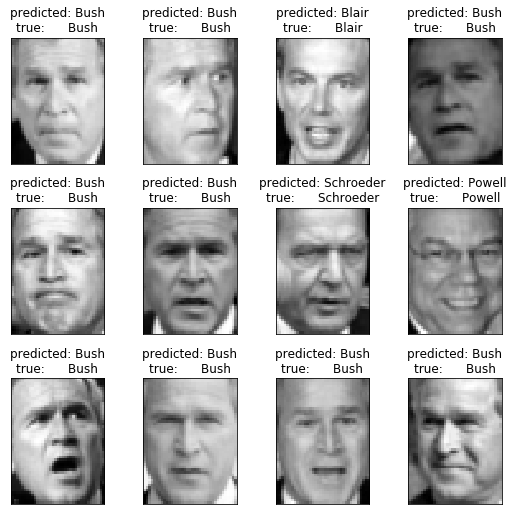

In [22]:
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())

# plotting the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                         for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

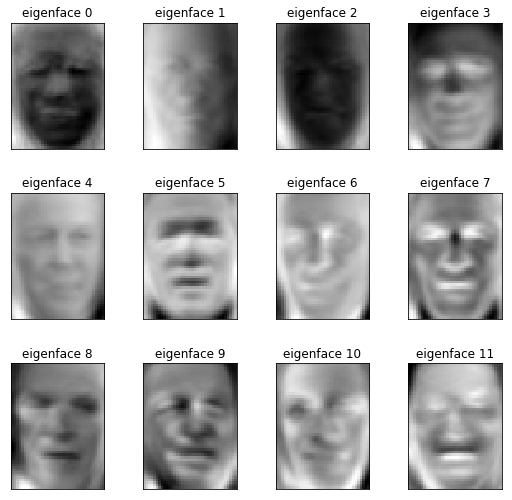

In [23]:
# plotting the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

pl.show()